### Задание к Уроку 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности
6. Ссылки


- http://hyperopt.github.io/hyperopt/
- https://arxiv.org/pdf/1907.03947.pdf
- https://arxiv.org/pdf/1802.02301.pdf
- https://arxiv.org/list/stat.ML/recent
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/compose.html

### Источник данных
набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

### Подключение библиотек

In [100]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


### Загрузка данных

In [101]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### EDA

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Есть как категориальные, так и вещественные признаки. Поле **CustomerId** нужно будет удалить. И возможно  **RowNumber**

### Распределение классов целевой переменной

In [103]:
df['Exited'].value_counts() / df['Exited'].count() * 100


0    79.63
1    20.37
Name: Exited, dtype: float64

### Разделение данных на train/test

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

### Генерация переменных

In [105]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]



### Отбор переменных

In [106]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']


### Проверка на примере отдельного категориального признака - Gender

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
    ('selector', FeatureSelector(column='Gender')),
    ('ohe', OHEEncoder(key='Gender'))
])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


### Генерация переменных 2

In [108]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

feature_processing = Pipeline([('feats', FeatureUnion(final_transformers))])

# feats = FeatureUnion(final_transformers)
# feature_processing = Pipeline([('feats', feats)])


In [110]:
from sklearn import set_config

set_config(display='diagram')
feature_processing

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenure'...
                                                                  StandardScaler())])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))]))])

### Программные блоки

Нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [111]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve,    confusion_matrix

def print_sel_thresholds(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix]

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [113]:
def confusion_matrix_create(y_test, preds, thresholds):
    font = {'size': 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds > thresholds)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

In [ ]:
models_results = {
    'approach': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
}

### I. Обучение модели. RandomForestClassifier

In [114]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)


In [115]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])


In [116]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

#### I.1 Расчет прогнозов для тестовой выборки

In [117]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]


array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

#### I.2 Переход от вероятностей к меткам класса. Подбор порога


In [118]:
thresholds=print_sel_thresholds(y_test, preds)


Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


#### I.3 Отображение матрицы ошибок

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


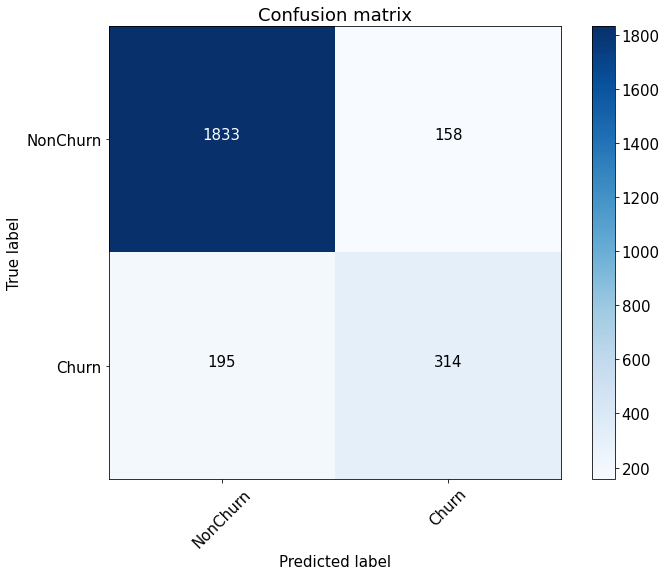

In [119]:
confusion_matrix_create(y_test, preds, thresholds)


> При стандартных настройках модель **RandomForestClassifier** дает небольшие значения метрик
- F-Score=0.641,
- Precision=0.653,
- Recall=0.629

### II. Обучение модели. LogisticRegression

#### сборка конвеера

In [120]:
model = LogisticRegression(random_state=42)

In [121]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])


In [122]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(random_state=42))])

#### II.1 Расчет прогнозов для тестовой выборки

In [123]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

#### II.2 Переход от вероятностей к меткам класса. Подбор порога


In [124]:
thresholds=print_sel_thresholds(y_test, preds)

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


#### II.3 Отображение матрицы ошибок

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


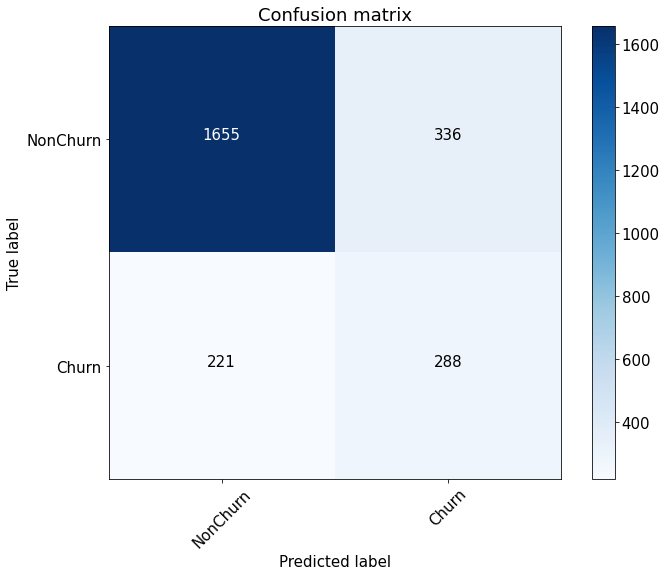

In [125]:
confusion_matrix_create(y_test, preds, thresholds)



> При стандартных настройках модель **LogisticRegression** дает небольшие значения метрик
- F-Score=0.510,
- Precision=0.462,
- Recall=0.568



### III. Обучение модели. AdaBoostClassifier

#### сборка конвеера

In [138]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100)

In [139]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])


In [140]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', AdaBoostClassifier(n_estimators=100))])

#### III.1 Расчет прогнозов для тестовой выборки

In [141]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.49746813, 0.49831574, 0.49496487, 0.49474028, 0.49263549,
       0.49896141, 0.48945302, 0.48996406, 0.49979683, 0.49700692])

#### III.2 Переход от вероятностей к меткам класса. Подбор порога


In [142]:
thresholds=print_sel_thresholds(y_test, preds)

Best Threshold=0.498955, F-Score=0.619, Precision=0.630, Recall=0.609


#### III.3 Отображение матрицы ошибок

Confusion matrix, without normalization
[[1809  182]
 [ 200  309]]


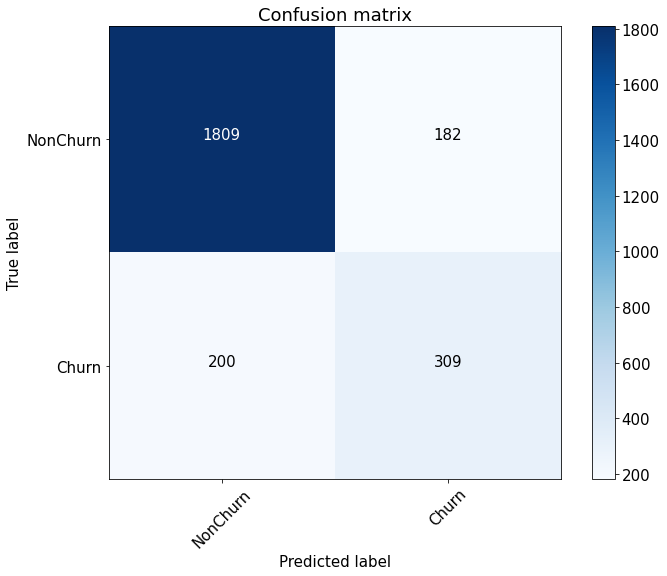

In [143]:
confusion_matrix_create(y_test, preds, thresholds)


> При стандартных настройках модель **AdaBoostClassifier** дает высокие значения метрик
- F-Score=0.619,
- Precision=0.630,
- Recall=0.609


#### IV Выбор модели

